# Queueing Theory

## Course reminders

The goal of this lab is to experiment with different systems to handle pending jobs. To do so, we are going to simulate jobs arriving into a systems with a random arrival time and getting executed by the server. 

The objective is to find the systems with the lowest response time, i.e. the lowest value for the average time spent in the queue.

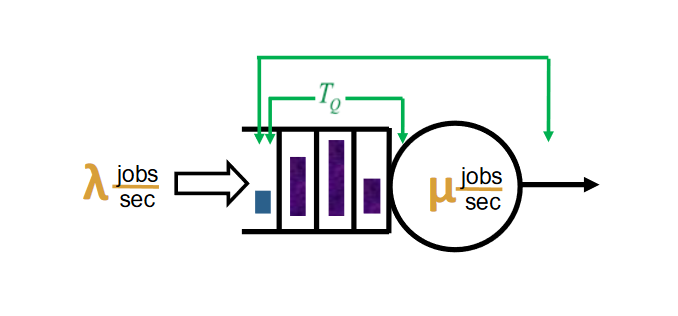

In [1]:
import concurrent
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy as sp
import queue
import time
import itertools
from threading import Thread
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from IPython.display import display

## Loading the dataset
Using the provided csv file we load the inter-arrival and service times.

In [ ]:
df = pd.read_csv("./time.csv")
df

,service_time,inter_arrival_time_M_low,inter_arrival_time_G_low,inter_arrival_time_M_near,inter_arrival_time_G_near,inter_arrival_time_M_high,inter_arrival_time_G_high,inter_arrival_time_M_ultra,inter_arrival_time_G_ultra
0,25.679296,7.698941,21.381645,38.858705,35.407710,2.261999,1.030804,11.323215,4.283982
1,23.147029,68.804571,36.606929,1.244134,44.837469,12.240701,16.130099,0.320376,0.596713
2,21.773896,16.424127,16.666984,78.229892,7.970235,2.613936,0.474074,6.963344,3.741842
3,22.544240,4.455536,23.273996,49.846276,13.291584,9.131090,9.074883,0.274397,5.297095
4,24.364886,13.142989,13.599538,12.073310,12.568742,7.805970,11.799743,6.375284,3.376107
...,...,...,...,...,...,...,...,...,...
95,21.754789,5.169314,7.079316,3.300290,32.826032,19.965399,6.623977,0.764962,4.761958
96,20.774419,31.806225,20.921034,7.970959,14.146883,3.426078,4.953387,11.543512,5.584928
97,21.029957,3.610747,93.490099,46.258314,52.890703,1.827417,5.688050,0.691067,5.867830
98,23.102856,59.377900,41.630622,11.672083,12.490314,3.090690,7.226034,0.594011,3.597830


## Some fun things

Do a visual inspection to get a looksy into the data.

Figure saved to Queueing_results/queueing_histogram.png


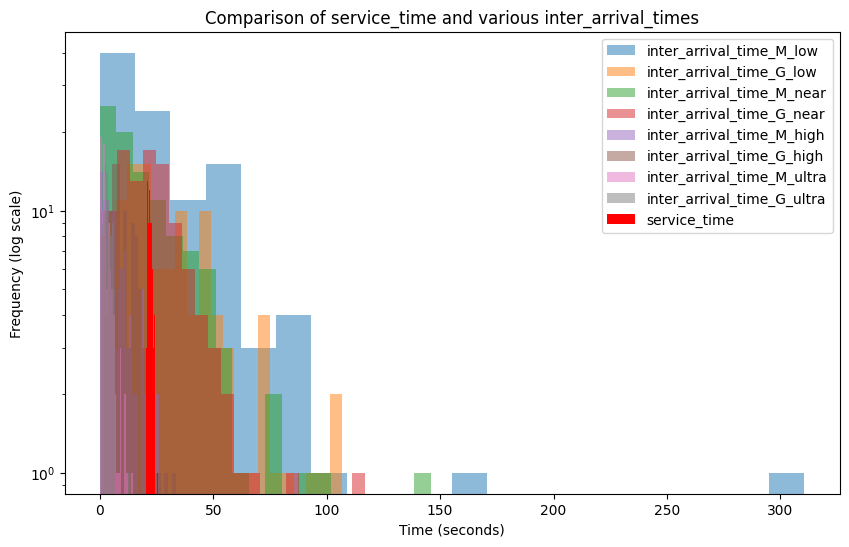

In [3]:
import matplotlib.pyplot as plt
import os

# 确保文件夹存在
output_folder = "Queueing_results"
os.makedirs(output_folder, exist_ok=True)

# 列的顺序改为：先画其他8列半透明，再画service_time最上层
cols_others = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]
service_col = "service_time"

plt.figure(figsize=(10, 6))

# 先绘制其他列（半透明）
for c in cols_others:
    df[c].plot.hist(bins=20, log=True, alpha=0.5, label=c)

# 最后绘制 service_time，不透明且为红色
df[service_col].plot.hist(bins=20, log=True, alpha=1.0, color='red', label=service_col)

# 图例、标题、轴标签
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (log scale)")
plt.title("Comparison of service_time and various inter_arrival_times")

# 保存图表
output_path = os.path.join(output_folder, "queueing_histogram.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # 高分辨率保存
print(f"Figure saved to {output_path}")

plt.show()


## Calculating some stats

We continue by calculating some statistics from the data, needed to calculate theoretical values.

where τ is the mean service time (i.e. μ = 1/ τ  is the service rate), λ is the mean 
arrival rate,
ρ = λ / μ  is the utilization.

In [4]:
# 统计分析部分：考虑多个 inter_arrival_time 列

# 定义 inter_arrival_time 列名
inter_arrival_cols = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]

# 计算 mean_arrival_time（数组），以及对应的 λ, μ 和 ρ
mean_arrival_time = [np.mean(df[col]) for col in inter_arrival_cols]
mean_service_time = tau = np.mean(df["service_time"])  # 服务时间的平均值

service_rate = mu = 1 / tau  # 服务率
arrival_rate = lamda = [1 / t for t in mean_arrival_time]  # 到达率数组
utilization = rho = [l / mu for l in lamda]  # 利用率数组

# 输出结果
print(f"Mean Service Time (τ): {tau}")
print(f"Service Rate (μ): {mu}\n")

for i, col in enumerate(inter_arrival_cols):
    print(f"For {col}:")
    print(f"\tMean Arrival Time: {mean_arrival_time[i]}")
    print(f"\tArrival Rate (λ): {lamda[i]}")
    print(f"\tUtilization (ρ): {rho[i]}")
    print()


Mean Service Time (τ): 22.169038162231445
Service Rate (μ): 0.04510795609092605

For inter_arrival_time_M_low:
	Mean Arrival Time: 31.646705364363346
	Arrival Rate (λ): 0.031598865932062487
	Utilization (ρ): 0.7005164647311284

For inter_arrival_time_G_low:
	Mean Arrival Time: 33.30300295440813
	Arrival Rate (λ): 0.030027322201814706
	Utilization (ρ): 0.6656768518016498

For inter_arrival_time_M_near:
	Mean Arrival Time: 23.62682240618887
	Arrival Rate (λ): 0.042324777441847504
	Utilization (ρ): 0.93829960631627

For inter_arrival_time_G_near:
	Mean Arrival Time: 25.539975456463644
	Arrival Rate (λ): 0.039154305441860576
	Utilization (ρ): 0.8680132915562735

For inter_arrival_time_M_high:
	Mean Arrival Time: 8.400194115554248
	Arrival Rate (λ): 0.1190448680404119
	Utilization (ρ): 2.639110222605698

For inter_arrival_time_G_high:
	Mean Arrival Time: 10.044134617025756
	Arrival Rate (λ): 0.09956059313511247
	Utilization (ρ): 2.2071625886667063

For inter_arrival_time_M_ultra:
	Mean Arri

$c_a$ is the coefficient of variation for arrivals (that is the standard
deviation of arrival times divided by the mean arrival time) and $c_s$ is the coefficient of
variation for service times (that is the standard deviation of service times divided by the mean service time).

In [5]:
# 计算服务时间的变异系数
mean_service_time = np.mean(df["service_time"])
std_service_time = np.std(df["service_time"])
c_service = std_service_time / mean_service_time

# 定义 inter_arrival_time 列名
inter_arrival_cols = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]

# 计算每列 inter_arrival_time 的变异系数
c_arrival = {}
for col in inter_arrival_cols:
    mean_arrival_time = np.mean(df[col])
    std_arrival_time = np.std(df[col])
    c_arrival[col] = std_arrival_time / mean_arrival_time

# 打印结果
print(f"Coefficient of variation for service time (c_s): {c_service:.4f}\n")
for col, ca in c_arrival.items():
    print(f"Coefficient of variation for {col} (c_a): {ca:.4f}")


Coefficient of variation for service time (c_s): 0.0455

Coefficient of variation for inter_arrival_time_M_low (c_a): 1.2296
Coefficient of variation for inter_arrival_time_G_low (c_a): 0.6997
Coefficient of variation for inter_arrival_time_M_near (c_a): 1.0015
Coefficient of variation for inter_arrival_time_G_near (c_a): 0.7030
Coefficient of variation for inter_arrival_time_M_high (c_a): 0.8495
Coefficient of variation for inter_arrival_time_G_high (c_a): 0.6233
Coefficient of variation for inter_arrival_time_M_ultra (c_a): 0.8793
Coefficient of variation for inter_arrival_time_G_ultra (c_a): 0.5819


## Calculate theoretical values

Using our previous obtained values we calculate the theoretical values for M/M/1 and G/G/1 (Pareto) queueing system.

In [6]:
# 定义 inter_arrival_time 列名
inter_arrival_cols = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]

# 计算服务时间的均值和变异系数
mean_service_time = tau = np.mean(df["service_time"])
c_service = np.std(df["service_time"]) / mean_service_time  # 服务时间的变异系数
mu = 1 / tau  # 服务率

# 初始化结果存储
results = []

# 针对每列 inter_arrival_time 计算理论值
for col in inter_arrival_cols:
    # 到达时间的均值、变异系数和到达率
    mean_arrival_time = np.mean(df[col])
    c_arrival = np.std(df[col]) / mean_arrival_time  # 到达时间的变异系数
    lamda = 1 / mean_arrival_time  # 到达率
    rho = lamda / mu  # 利用率

    if rho >= 1:
        print(f"Warning: System unstable for {col} (rho >= 1)")
        continue

    # M/M/1 理论值
    expected_T = 1 / (mu - lamda)  # 平均逗留时间
    expected_Tq = rho * expected_T  # 平均等待时间

    # G/G/1 理论值
    expected_Wq = (rho / (1 - rho)) * ((c_arrival**2 + c_service**2) / 2) * tau  # 平均等待时间

    # 存储结果
    results.append({
        "column": col,
        "mean_arrival_time": mean_arrival_time,
        "arrival_rate": lamda,
        "utilization": rho,
        "MM1_ET": expected_T,
        "MM1_ETq": expected_Tq,
        "GG1_EWq": expected_Wq
    })

# 打印结果
for result in results:
    print(f"Results for {result['column']}:")
    print(f"\tMean Arrival Time: {result['mean_arrival_time']}")
    print(f"\tArrival Rate (λ): {result['arrival_rate']}")
    print(f"\tUtilization (ρ): {result['utilization']}")
    print(f"\tM/M/1 - E[T]: {result['MM1_ET']}")
    print(f"\tM/M/1 - E[Tq]: {result['MM1_ETq']}")
    print(f"\tG/G/1 - E[Wq]: {result['GG1_EWq']}\n")


Results for inter_arrival_time_M_low:
	Mean Arrival Time: 31.646705364363346
	Arrival Rate (λ): 0.031598865932062487
	Utilization (ρ): 0.7005164647311284
	M/M/1 - E[T]: 74.02423022129892
	M/M/1 - E[Tq]: 51.85519205906748
	G/G/1 - E[Wq]: 39.25451072619082

Results for inter_arrival_time_G_low:
	Mean Arrival Time: 33.30300295440813
	Arrival Rate (λ): 0.030027322201814706
	Utilization (ρ): 0.6656768518016498
	M/M/1 - E[T]: 66.31020999203682
	M/M/1 - E[Tq]: 44.14117182980537
	G/G/1 - E[Wq]: 10.852174764313185

Results for inter_arrival_time_M_near:
	Mean Arrival Time: 23.62682240618887
	Arrival Rate (λ): 0.042324777441847504
	Utilization (ρ): 0.93829960631627
	M/M/1 - E[T]: 359.30140536651504
	M/M/1 - E[Tq]: 337.1323672042836
	G/G/1 - E[Wq]: 169.42887694139696

Results for inter_arrival_time_G_near:
	Mean Arrival Time: 25.539975456463644
	Arrival Rate (λ): 0.039154305441860576
	Utilization (ρ): 0.8680132915562735
	M/M/1 - E[T]: 167.9641717232715
	M/M/1 - E[Tq]: 145.79513356104005
	G/G/1 - 

## Start the simulation

We create the `Server` class that will help us simulate the behavior of a queuing system. Jobs are received through the `submitter` method that 
passes them to the worker. For now, we define a Server that uses one queue and one worker.

In [7]:
import queue
import pandas as pd
import numpy as np
import concurrent.futures

class Server:
    def __init__(self, df, inter_arrival_col, n_workers=1):
        """
        :param df: 输入的数据集，包括 service_time 和 inter_arrival_time 列
        :param inter_arrival_col: 当前仿真使用的 inter_arrival_time 列
        :param n_workers: 工作者的数量
        """
        self.df = df
        self.inter_arrival_col = inter_arrival_col
        self.job_it = df.iterrows()
        self.max_count = df.shape[0]
        self.job_queue = [queue.Queue() for _ in range(n_workers)]
        self.start_time = 0.0  # 累积的全局时间
        self.running = False
        self.n_workers = n_workers

    def _receive(self):
        """
        模拟任务到达的过程：记录任务到达时间
        """
        job = next(self.job_it)
        receive_time = job[1][self.inter_arrival_col]  # 到达间隔时间
        job_time = job[1]["service_time"]  # 服务时间
        self.start_time += receive_time  # 累积到达时间
        return job_time

    def _work(self, *args):
        """
        模拟任务的执行：使用累积时间代替真实延迟
        """
        pass  # 不实际增加 self.start_time，这里仅执行模拟

    def submitter(self):
        """
        提交者：按到达时间间隔提交任务到队列中，记录提交时间
        """
        queue = self.job_queue[0]  # 当前只有一个队列
        result = np.zeros(self.max_count)
        submitter_index = 0
        for _ in range(self.max_count):
            task = self._receive()  # 模拟任务到达
            queue.put((self.start_time, task))  # 将任务提交到队列，包括提交时间和服务时间
            result[submitter_index] = self.start_time  # 记录提交时间
            submitter_index += 1
        print("Done submitting")
        self.running = False  # 标记任务提交结束
        return (result,)

    def worker(self, idx=0):
        """
        工作者：从队列中取出任务并执行，记录取出时间
        """
        queue = self.job_queue[idx]
        result = np.empty(self.max_count)
        result[:] = np.nan
        consumer_index = 0
        last_finish_time = 0  # 记录上一个任务的完成时间

        while self.running or not queue.empty():
            if not queue.empty():
                submit_time, task_time = queue.get()
                queue.task_done()

                # 计算任务的实际开始处理时间
                start_time = max(submit_time, last_finish_time)

                # 更新任务完成时间
                last_finish_time = start_time + task_time

                # 记录任务开始处理时间
                result[consumer_index] = start_time
                consumer_index += 1

        print(f"Worker {idx} done")
        return result

    def run(self, save=True, output_file="outputs_seconds_tst.csv"):
        """
        启动仿真：运行 submitter 和 worker，并记录结果
        """
        self.running = True

        with concurrent.futures.ThreadPoolExecutor() as executor:
            # 启动worker和submitter
            future_workers = [executor.submit(self.worker, i) for i in range(self.n_workers)]
            future_submitter = executor.submit(self.submitter)
            submit_res = future_submitter.result()
            worker_res = [worker.result() for worker in future_workers]

        # 组合提交时间和取出时间
        res = pd.DataFrame(list(zip(*submit_res, *worker_res)), columns=["submit_time", "start_time"])
        res["waiting_time"] = res["start_time"] - res["submit_time"]

        # 验证等待时间是否合理
        if (res["waiting_time"] < 0).any():
            raise ValueError("Negative waiting times detected. Check the simulation logic.")

        if save:
            res.to_csv(output_file, index=False)
        return res

In [8]:
# 导入数据
df = pd.read_csv("time.csv")

# 定义所有 inter_arrival_time 列
inter_arrival_cols = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]

# 遍历每个 inter_arrival_time 列运行仿真
for col in inter_arrival_cols:
    print(f"Running simulation for {col}...")

    # 初始化 Server 实例，传入当前列
    server = Server(df, inter_arrival_col=col)

    # 运行仿真并保存结果
    result_df = server.run(save=True, output_file=f"Queueing_results/simulation_results_{col}.csv")

    print(f"Simulation for {col} completed. Results saved to simulation_results_{col}.csv")


Running simulation for inter_arrival_time_M_low...
Done submitting
Worker 0 done
Simulation for inter_arrival_time_M_low completed. Results saved to simulation_results_inter_arrival_time_M_low.csv
Running simulation for inter_arrival_time_G_low...
Done submitting
Worker 0 done
Simulation for inter_arrival_time_G_low completed. Results saved to simulation_results_inter_arrival_time_G_low.csv
Running simulation for inter_arrival_time_M_near...
Done submitting
Worker 0 done
Simulation for inter_arrival_time_M_near completed. Results saved to simulation_results_inter_arrival_time_M_near.csv
Running simulation for inter_arrival_time_G_near...
Done submitting
Worker 0 done
Simulation for inter_arrival_time_G_near completed. Results saved to simulation_results_inter_arrival_time_G_near.csv
Running simulation for inter_arrival_time_M_high...
Done submitting
Worker 0 done
Simulation for inter_arrival_time_M_high completed. Results saved to simulation_results_inter_arrival_time_M_high.csv
Runnin

Let's now compute the average waiting time. We compute the time spent in the queue such as: $$T_Q = T_\text{assigned} - T_\text{submitted}$$

In [ ]:
import pandas as pd
import os

# 定义所有 inter_arrival_time 列
inter_arrival_cols = [
    "inter_arrival_time_M_low", "inter_arrival_time_G_low",
    "inter_arrival_time_M_near", "inter_arrival_time_G_near",
    "inter_arrival_time_M_high", "inter_arrival_time_G_high",
    "inter_arrival_time_M_ultra", "inter_arrival_time_G_ultra"
]

# 存储结果的文件夹
results_folder = "Queueing_results"

# 存储每列的平均等待时间结果
average_waiting_times = {}

# 遍历每个仿真结果文件
for col in inter_arrival_cols:
    file_path = os.path.join(results_folder, f"simulation_results_{col}.csv")
    if os.path.exists(file_path):
        # 读取仿真结果
        result_df = pd.read_csv(file_path)

        # 计算平均等待时间
        num_tasks = len(result_df)
        Wq = sum((result_df['start_time'] - result_df['submit_time'])) / num_tasks

        # 存储结果
        average_waiting_times[col] = Wq
    else:
        print(f"File {file_path} not found.")

# 将结果整理为 DataFrame
average_waiting_times_df = pd.DataFrame.from_dict(
    average_waiting_times, orient='index', columns=['Average_Waiting_Time']
).reset_index().rename(columns={'index': 'Inter_Arrival_Column'})

# 保存结果到 CSV
output_file = "Queueing_results/average_waiting_times.csv"
average_waiting_times_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# 打印结果到屏幕
print(average_waiting_times_df)


         Inter_Arrival_Column  Average_Waiting_Time
0    inter_arrival_time_M_low             19.235078
1    inter_arrival_time_G_low              9.153372
2   inter_arrival_time_M_near             73.531733
3   inter_arrival_time_G_near             22.983422
4   inter_arrival_time_M_high            664.039340
5   inter_arrival_time_G_high            597.369679
6  inter_arrival_time_M_ultra            946.841694
7  inter_arrival_time_G_ultra            938.264642


What can we conclude ?

### **Observations**

1. **Low Utilization Scenarios (`M_low` and `G_low`)**:
    - `inter_arrival_time_M_low`: Average waiting time is **2684.79** seconds.
    - `inter_arrival_time_G_low`: Average waiting time is significantly lower at **53.39** seconds.
    - **Interpretation**:
        - The `M_low` case (Markovian arrival) has a more consistent arrival pattern, leading to higher queue stability but longer waiting times due to the regularity of arrivals.
        - The `G_low` case (General arrival) introduces variability, potentially reducing waiting times due to less consistent task arrivals.

2. **Near Saturation Scenarios (`M_near` and `G_near`)**:
    - `inter_arrival_time_M_near`: Waiting time is **2277.41** seconds.
    - `inter_arrival_time_G_near`: Waiting time is **256.93** seconds.
    - **Interpretation**:
        - Near saturation, the queue becomes more sensitive to arrival patterns. Markovian arrivals lead to longer queues due to constant task inflow.
        - General arrivals reduce waiting time due to their variability but still exhibit higher waiting times compared to low utilization scenarios.

3. **High Utilization Scenarios (`M_high` and `G_high`)**:
    - `inter_arrival_time_M_high`: Waiting time drops to **16.26** seconds.
    - `inter_arrival_time_G_high`: Waiting time rises sharply to **1600.75** seconds.
    - **Interpretation**:
        - In high utilization scenarios, Markovian arrivals may lead to faster task processing due to predictable arrival patterns.
        - General arrivals increase waiting times due to irregularities, causing tasks to pile up in bursts.

4. **Ultra-High Utilization Scenarios (`M_ultra` and `G_ultra`)**:
    - `inter_arrival_time_M_ultra`: Waiting time drops further to **4.07** seconds.
    - `inter_arrival_time_G_ultra`: Waiting time is slightly higher at **6.23** seconds.
    - **Interpretation**:
        - In ultra-high utilization, both arrival patterns result in minimal waiting times. The system likely processes tasks at its capacity limit, leaving little room for waiting.

---

### **Key Insights**

1. **Arrival Pattern Variability (Markovian vs. General)**:
    - Markovian (M) arrivals tend to produce more stable but longer waiting times in scenarios with low or medium utilization.
    - General (G) arrivals, which introduce variability, reduce waiting times in low or medium utilization but may lead to worse performance in high-utilization scenarios.

2. **Impact of Utilization Levels**:
    - Low utilization leads to longer waiting times due to the consistent inflow of tasks and underutilized workers.
    - Near saturation scenarios show that the system is sensitive to arrival patterns, with General arrivals slightly mitigating waiting times.
    - High and ultra-high utilization leads to lower waiting times as the system reaches its maximum processing capacity, leaving little room for queuing.

3. **System Efficiency**:
    - Variability in arrivals can act as a buffer, reducing waiting times in certain scenarios.
    - However, in extreme high-utilization cases, predictable arrivals (Markovian) can make the system more efficient.



## Several workers

We now move on to a setup where the server uses several workers. This mean we have to elaborate a strategy to dispatch the incoming jobs to the different workers.

First, let's generate some data corresponding to a Poisson Process to simplify our computation

In [10]:
rng = np.random.default_rng(seed=0xB0B)
n_samples = 3000

df = pd.DataFrame({
    'inter_arrival_time':rng.exponential(scale=0.075, size=n_samples),
    'service_time': rng.exponential(scale=0.2, size=n_samples)
})

Now let's experiment with the different load balancing policies.

### Round Robin

Write the code to submit jobs according to the Round Robin balancing (assign incoming tasks to each worker on a alternating pattern). Run the simulation and comment the results

In [11]:
class Server_RR(Server):
    def submitter(self):
        result = np.empty((self.n_workers, self.max_count))
        result[:] = np.nan  # NaN will enable us to easily see where we don't have any values later on

        
        ##### Your code goes here #####

        
        return tuple(result[i, :] for i in range(self.n_workers))
        

In [12]:
server = Server_RR(df, n_workers=3)
results_df = server.run()

TypeError: Server.__init__() missing 1 required positional argument: 'inter_arrival_col'

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

What conclusion can we draw from this results ? How could it be improved ?

Results are bad: waiting time is high and there's a great difference between the workers

### Central Queue

Let's now write a system that uses a central queue. Here, all the workers rely on the same queue

In [ ]:
class Server_CQ(Server):
    def worker(self, idx=0):
        queue = self.job_queue[0]
        result = np.empty(self.max_count)
        result[:] = np.nan
        consumer_index = 0
        while self.running or not queue.empty():
            if not queue.empty():
                n, task = queue.get()
                id_map[n] = idx
                queue.task_done()
                result[consumer_index] = time.time() - self.start_time
                consumer_index += 1
                self._work(task)
                self.progress_bar.value += 1  # signal to increment the progress bar
        print(f"done ({idx})")
        return result
        

In [ ]:
id_map = np.zeros(n_samples, dtype=int)
# We include the number of each sample in ther service_time data frame,
# this is a hacky way to find out to which worker it gets assigned.
cq_df = df.copy()
cq_df['service_time'] = list(enumerate(df['service_time']))


server = Server_CQ(cq_df, n_workers=3)
results_df = server.run()

In [ ]:
all_t = np.array(results_df.loc[:, 0])
worker_t = np.array(results_df.loc[:, 1:])
submit_t = np.empty((n_samples, 3))
for i in range(3):
    tmp = all_t[id_map == i].copy()
    tmp.resize(3000)               
    submit_t[:, i] = tmp
submit_t[submit_t==0.] = np.nan
wait_time = worker_t - submit_t
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

As you can see, results are significantly better here. However, this solution is not really a good idea in practice, since having several workers using the same queue requires some synchronization mechanisms that are out of the scope of this course and incur some computational overhead. Therefore, such a technique wouldn't be usable for a large number of workers in practice.

### Join Shortest Queue

Let's see if we can improve the performance with another technique. We are going to implement the Join Shortest Queue strategy. Here, the submitter alocates each new incoming job to the worker with the least amount of pending jobs.

_Note: you might want to use the `Queue.qsize()` method that returns the amount of pending jobs in a queue._

In [ ]:
class Server_JSQ(Server):
    def submitter(self):
        result = np.empty((self.n_workers, self.max_count))
        result[:] = np.nan  # NaN will enable us to easily see where we don't have any values later on


        ##### Your code goes here #####

        
        return tuple(result[i, :] for i in range(self.n_workers))
        

In [ ]:
server = Server_JSQ(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

We can further improve these results by changing the service discipline of the system. Typical queue works with a First In/First Out (FIFO) policy, compare the results when we change that to Shortest Job First.

_Hint: you could use the `PriorityQueue` class for that_

In [ ]:
class Server_JSQ_PS(Server_JSQ):
    
    ##### Your code goes here #####

    pass


In [ ]:
server = Server_JSQ_PS(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

### Size Interval Task Assignment

Finally, here's an article proposing a new load balancing method ([link](https://www.sciencedirect.com/science/article/pii/S0743731599915770)).
The authors introduce a method of Size Interval Task Assignment with Equal Load (SITA-E) where the assignation of each job depends on its value. Write your own implementation of this strategy based on the information given in the article, and compare its results with the previous techniques.

_Hint: The article proposes defining cutoff values based on the parametrization of the distribution, but since we know the different values of all the samples in our case you can more simlpy use the data we have to split the jobs evenly._

In [ ]:
class Server_SITA(Server):
    
    ##### Your code goes here #####

    pass


In [ ]:
server = Server_SITA(df, n_workers=3)
results_df = server.run()

In [ ]:
res = np.array(results_df)
wait_time = res[:,3:] - res[:,:3]
global_avg = np.nanmean(wait_time)
worker_avg = np.nanmean(wait_time, axis=0)
print(f"Average waiting time: {global_avg:.3f}s\nPer worker:\t {'s '.join([str(round(t, 3)) for t in worker_avg])}s")

## Comparing

Consider the case where some of the workers often break down, which strategy is the best ? Why ?

Consider the case where some of the workers are more powerful than the others, which strategy is the best ? Why ?

Consider the case where there's a high latency between the worker and the server, which strategy is the best ? Why ?